In [151]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [152]:
import re

from os import walk
from os.path import join

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, show

# Read classes from file
labels = np.genfromtxt('../classes.csv', delimiter=',', dtype=str)
# because of space after comma we read redundant empty column
labels = np.array([l[0] for l in labels])

data_path = "../database/"
files = list()
for (dirpath, dirnames, filenames) in walk(data_path):
    files = filenames  
    
data_images = list()
data_labels = list()
label_from_name = r"([a-zA-z]+)[-_]\d+.pgm"

# here we load all the images and find their label from filename
for f in files:
    match = re.match(label_from_name, f)
    if match:
        label = match.groups()[0]
        if label in labels:
            data_labels.append(label)
            data_images.append(imread(join(data_path, f), as_grey=True))      
    else: 
        # if name does not match our regexp or label is not in the list
        # of classes - not read from database
        continue 

In [156]:
"""Set of utils for input image processing."""
import math

import numpy as np

from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.morphology import medial_axis
from skimage.measure import label

from scipy import interpolate

# Dictionary of increments of current pixel coordinates
# for finding a neighborhood with given connectivity
CONNECTIVITY_INC = {
    4: {
        0: (0, -1),
        1: (-1, 0),
        2: (0, 1),
        3: (1, 0)
    },
    8: {
        0: (0, -1),
        1: (-1, -1),
        2: (-1, 0),
        3: (-1, 1),
        4: (0, 1),
        5: (1, 1),
        6: (1, 0),
        7: (1, -1),
    }
}


def pad_image(im, color="b"):
    """Pad the image by one pixel."""
    if color == "b":
        padded_im = np.array(
            [np.concatenate([[0], row, [0]]) for row in im], dtype=np.uint8)
        new_row = np.zeros((1, padded_im.shape[1]), dtype=np.uint8)
        padded_im = np.concatenate([new_row, padded_im, new_row])
    else:
        raise ValueError("Padding is not implemented for thes color")
    return padded_im


def trace_border(im, connectivity=4):
    """Trace border with Moore-Neighbor Tracing."""
    border = list()
    # we pad image by one pixel from all sides
    # padding ensures us not to go out of domain
    padded_im = pad_image(im)

    background_pixel = padded_im[0][0]
    current_pixel = padded_im[0][0]
    start = None

    # find starting pixel
    for i in range(padded_im.shape[0]):
        for j in range(padded_im.shape[1]):
            if padded_im[i][j] != current_pixel:
                start = (i, j)
                border.append((i, j))
                break
        else:
            continue
            # executed if the loop ended normally (no break)
        break

    # iterations of the algo
    current_pixel = start
    direction = 0
    while (True):
        if connectivity == 8:
            i = (direction + 2) % 8
            while i != (direction + 7) % 8:
                next_pixel = (
                    current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                    current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    direction = (i + 4) % 8
                    break
                i = (i + 1) % 8
        elif connectivity == 4:
            i = (direction + 1) % 4
            while i != (direction + 4) % 8:
                next_pixel = (
                    current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                    current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    direction = (i + 2) % 4
                    break
                i = (i + 1) % 4
        else:
            raise ValueError("Invalid connectivity specified")
    # stop condition
        if current_pixel == border[0]:
            break
    # remove padding from image (it will influence border coordinates)
    border = [(pixel[0] - 1, pixel[1] - 1) for pixel in border]
    return border


def fill_border(im, border, point, color=255):
    """Fill the border."""
    image = np.array(im)
    next_points = [point]

    temporary_color = 120

    while len(next_points) > 0:
        point = next_points.pop()
        image[point] = temporary_color

        top = (point[0] - 1, point[1])
        down = (point[0] + 1, point[1])
        left = (point[0], point[1] - 1)
        right = (point[0], point[1] + 1)

        if image[top] != temporary_color and top not in border:
            next_points.append(top)
        if image[down] != temporary_color and down not in border:
            next_points.append(down)
        if image[left] != temporary_color and left not in border:
            next_points.append(left)
        if image[right] != temporary_color and right not in border:
            next_points.append(right)
    image[image == temporary_color] = color
    return image


def fill_foreground(image):
    """."""
    img_labels = label(image)
    label_count = np.bincount(img_labels.ravel())
    background = np.argmax(label_count)
    filled_image = image
    filled_image[img_labels != background] = 255
    return filled_image


def sample_border_points(border, size):
    """Sample points from the border uniformly."""
    sample_indices = np.sort(np.random.choice(range(len(border)), size=size))
    sampled_border = [p for i, p in enumerate(border) if i in sample_indices]
    return sampled_border


def smooth_border(im, disk_size=5):
    """Smooth the border with median filter."""
    new_im = np.array(im)
    new_im = median(new_im, disk(disk_size))
    return new_im


def medial_axis_skeleton(im):
    """Find skeleton and the distances of points on skeleton to the border."""
    skel, distance = medial_axis(im, return_distance=True)
    dist_on_skel = distance * skel
    return dist_on_skel



In [200]:
def preprocess_image(image):
    """."""
    im = pad_image(image)
    filled_image = fill_foreground(im)
    smoothed_image = smooth_border(filled_image)
    return smoothed_image

def preprocess_image_without_smooth(image):
    """."""
    im = pad_image(image)
    filled_image = fill_foreground(im)
    return filled_image

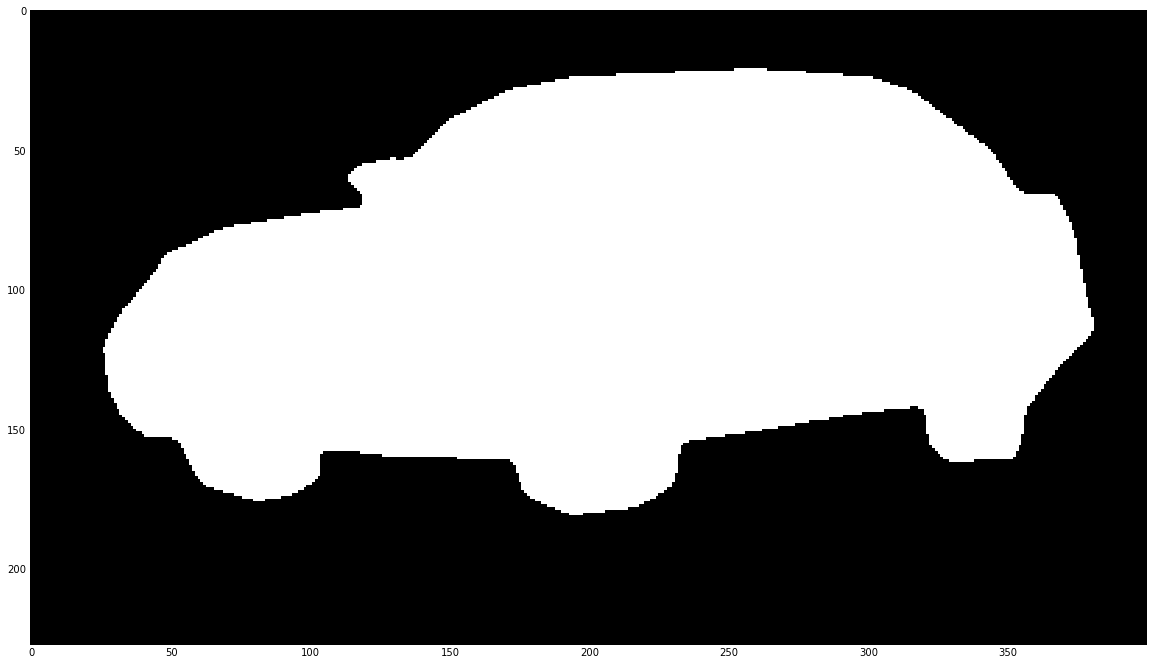

In [142]:
imshow(data_images[2])

In [143]:
car = data_images[2]
car_smooth = preprocess_image(car)

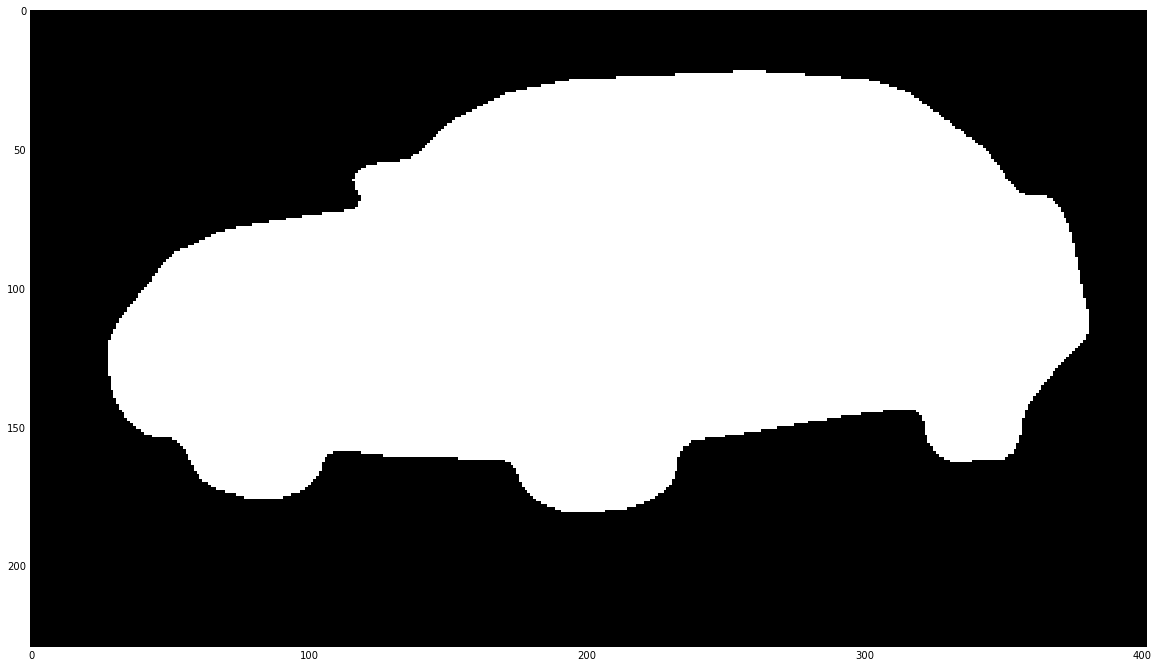

In [13]:
imshow(car_smooth)

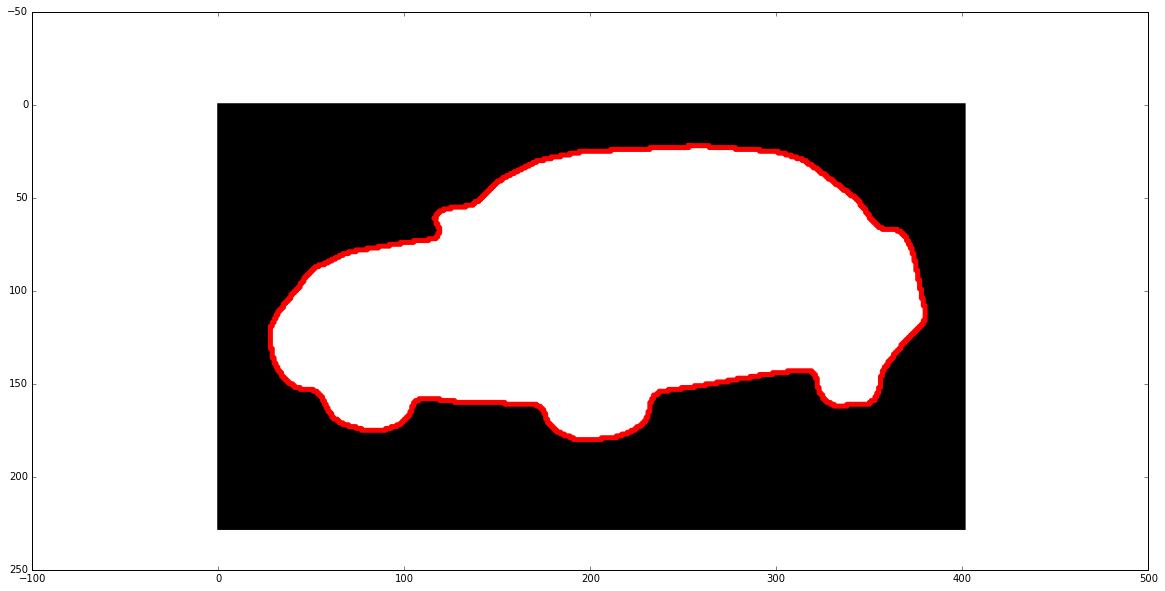

In [14]:
car_border = trace_border(car_smooth)

width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(car_smooth, cmap=plt.cm.gray)
ax.plot([b[1] for b in car_border], [b[0] for b in car_border], color="r", linewidth=5)

In [26]:
from scipy.interpolate import UnivariateSpline

def curvature_splines(x, y=None, error=0.1):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)
    return curvature

In [27]:
x_car = np.array([x for (x,y) in car_border])
y_car = np.array([y for (x,y) in car_border])

In [28]:
car_curvature = curvature_splines(x_car, y_car)

In [29]:
car_curvature

array([-0.01560109, -0.01482391, -0.01394505, ..., -0.00680775,
       -0.00724765, -0.00767191])

In [55]:
from sklearn.preprocessing import normalize

norm_car_curv = normalize(car_curvature, norm='max')

/home/et/softs/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [56]:
norm_car_curv

array([[-0.07047108, -0.0669605 , -0.06299062, ..., -0.030751  ,
        -0.03273807, -0.0346545 ]])

In [67]:
pos_car_curv = []
for x in norm_car_curv[0]:
    if x>=0:
        pos_car_curv.append(x)
    elif x<-1:
        pos_car_curv.append(1)
    else:
        pos_car_curv.append(-x)

In [68]:
pos_car_curv

[0.070471075202077266,
 0.066960502571160985,
 0.062990622731093709,
 0.058629860905862467,
 0.053952476483678971,
 0.04903602324108567,
 0.043958957838800536,
 0.038798496349997352,
 0.033628783371436939,
 0.028519405796286618,
 0.023534256336580725,
 0.018730731623806587,
 0.014159236213380872,
 0.0098629562587205996,
 0.0058778637440614579,
 0.0022329125979424903,
 0.001049609505692799,
 0.0039536063229639127,
 0.006468603996731024,
 0.0085891128409647383,
 0.010313941543885277,
 0.011645482264744858,
 0.012588982259356275,
 0.013151815000064911,
 0.013342761148669396,
 0.013171307110999536,
 0.012646966199112536,
 0.011778624635427505,
 0.010573911763514528,
 0.0090385909092199398,
 0.0071759643937003882,
 0.0049862832611975568,
 0.0024661493616762458,
 0.00039210547802784454,
 0.0036010813577436575,
 0.0071790343324648889,
 0.010902423918893171,
 0.014544830883621511,
 0.018123268545718035,
 0.021652694978655847,
 0.02514614826965746,
 0.028614845722298946,
 0.032068250341855641,


In [129]:
colors = [(curv, 0.1, 0.1) for curv in pos_car_curv]

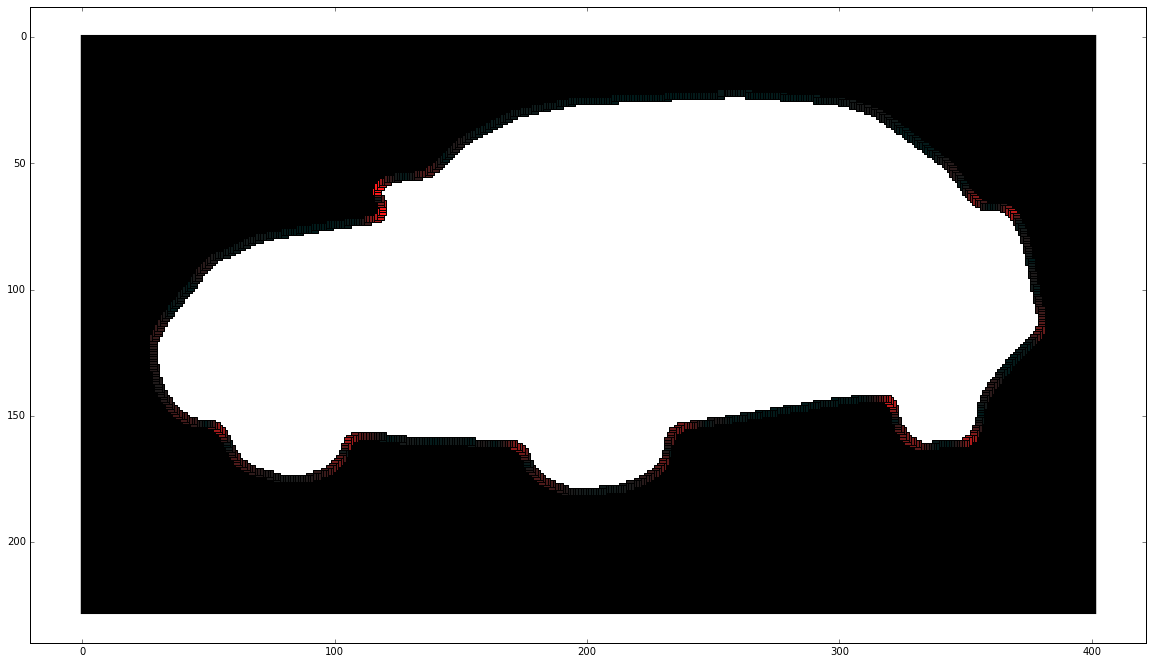

In [130]:
width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(car_smooth, cmap=plt.cm.gray)

ax.scatter([b[1] for b in car_border], [b[0] for b in car_border], c=colors, s=50, marker=',')

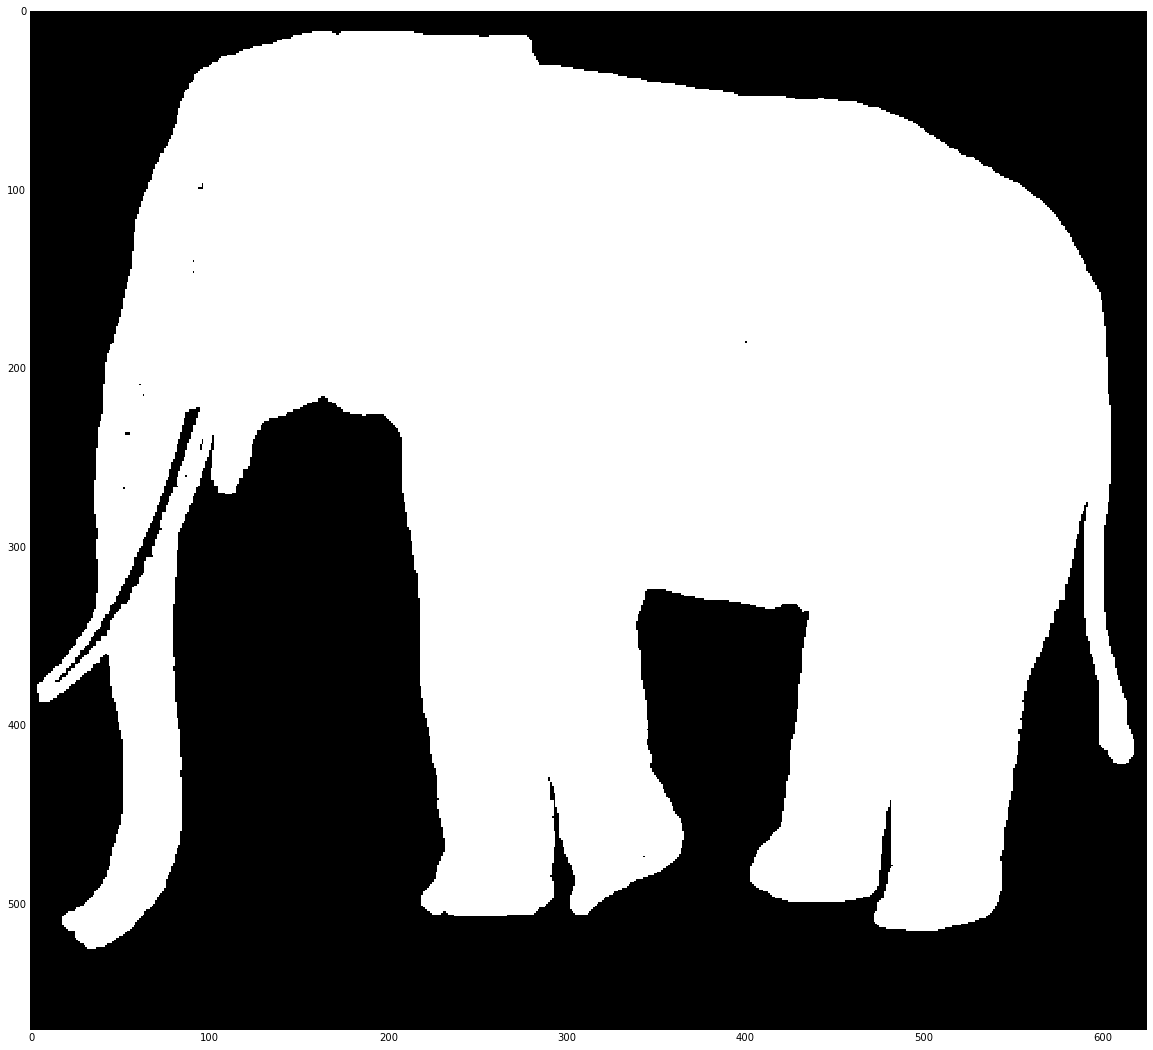

In [166]:
elephant = preprocess_image(data_images[4])

im = pad_image(data_images[4])
filled_image = fill_foreground(im)
imshow(filled_image)

/home/et/softs/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


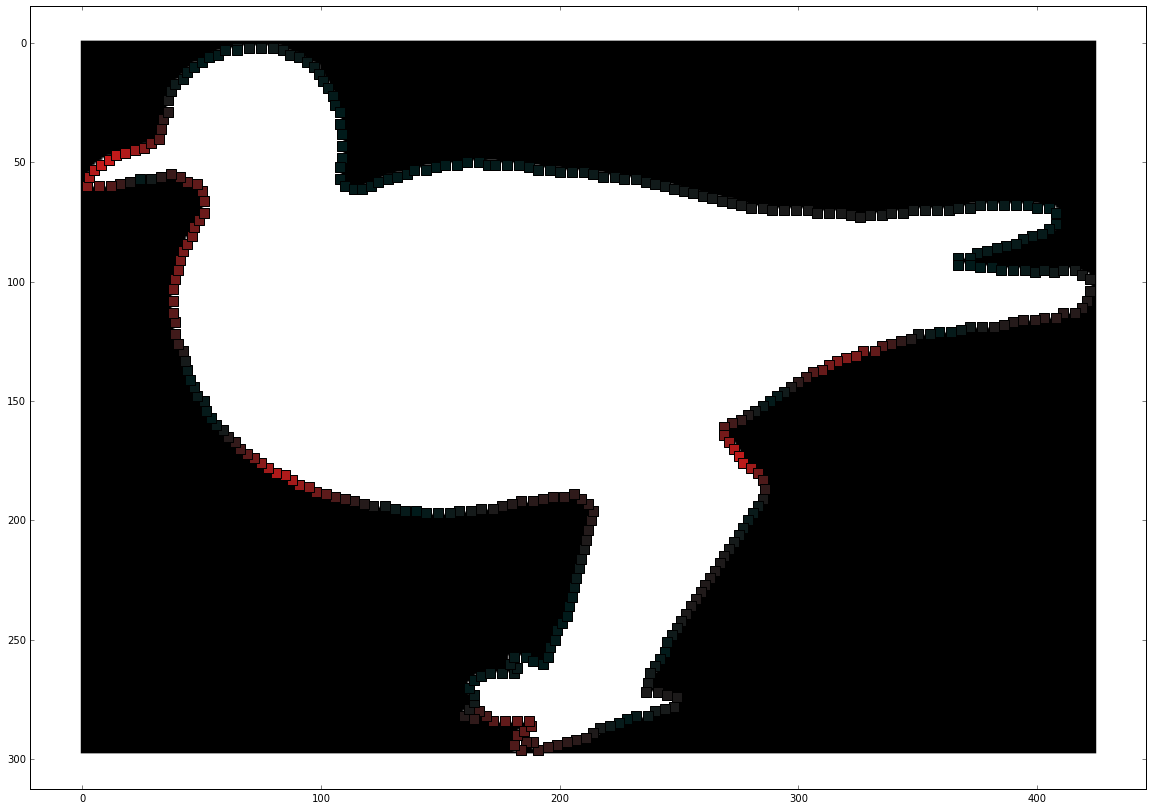

In [210]:
elephant2 = preprocess_image_without_smooth(data_images[32])

el2_dense_border = trace_border(elephant2)

el2_border = [el2_dense_border[i] for i in range(len(el2_dense_border)) if i%5 == 0]

x_el2 = np.array([x for (x,y) in el2_border])
y_el2 = np.array([y for (x,y) in el2_border])
curvs_el2 = curvature_splines(x_el2, y_el2)

norm_el2_curv = normalize(curvs_el2, norm='max')
pos_el2_curv = []
for x in norm_car_curv[0]:
    if x>=0:
        pos_el2_curv.append(x)
    elif x<-1:
        pos_el2_curv.append(1)
    else:
        pos_el2_curv.append(-x)

colors_el2 = [(curv, 0.1, 0.1) for curv in pos_el2_curv]


width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(elephant2, cmap=plt.cm.gray)

ax.scatter([b[1] for b in el2_border], [b[0] for b in el2_border], c=colors_el2, s=100, marker=',')

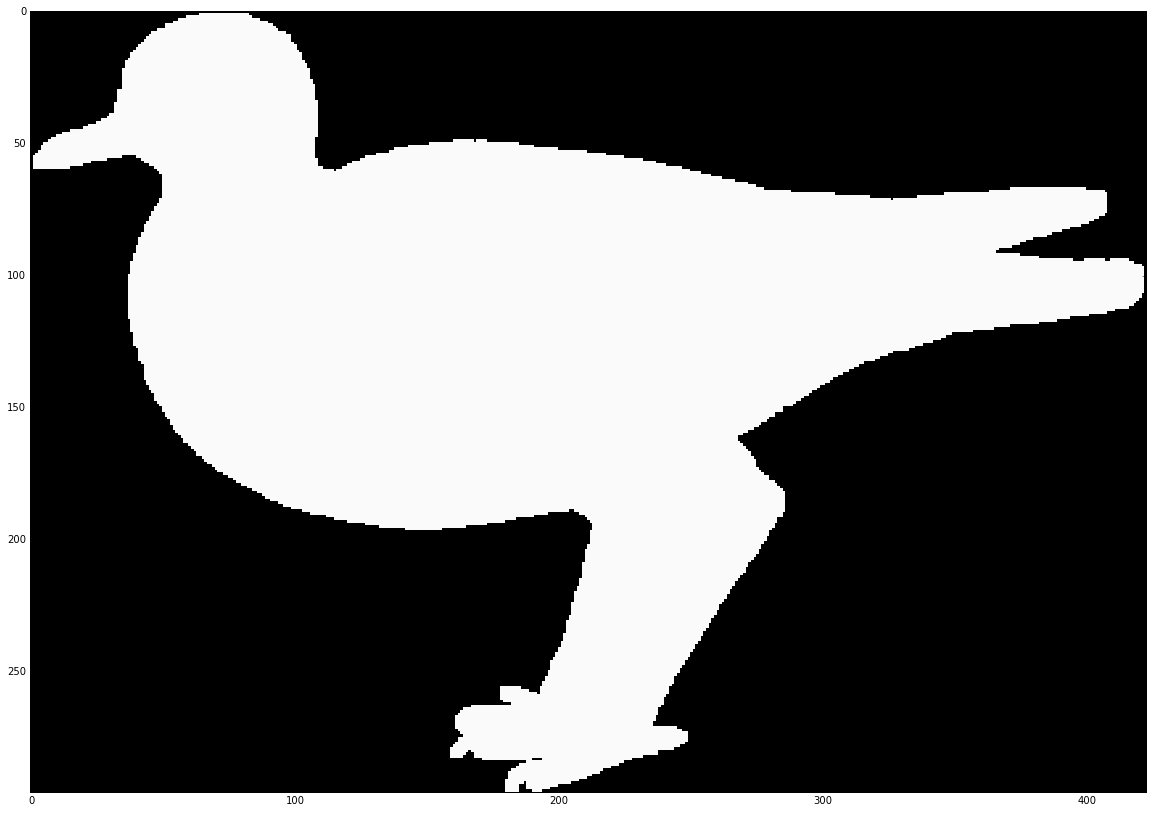

In [203]:
imshow(data_images[32])